In [1]:
"""Notebook for testing SynthSeg in MONAI
"""
import os
import requests
import torch
import matplotlib.pyplot as plt
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityd,
)
from monai.data import (
    Dataset,
    DataLoader,
    decollate_batch,
)
from monai.metrics import DiceMetric
from monai.utils import set_determinism

import transforms_synthseg as transforms
import utils_synthseg as utils

set_determinism(seed=0)
torch.backends.cudnn.benchmark = True

In [2]:
# Settings
url_data = "https://github.com/neurolabusc/niivue-images/raw/main"
dir_results = "./results"
spatial_size = (256,) * 3
patch_size = None
device = torch.device("cuda:0") 
model_pth = os.path.join(dir_results, 'model_best.pth')

In [3]:
# Download test data
fnames = ["chris_t1.nii.gz", "chris_t2.nii.gz"]
test_files = []
for fname in fnames:
    response = requests.get(os.path.join(url_data, fname), stream=True)
    if response.status_code == 200:
        with open(fname, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {fname}")
        test_files.append({"image": fname})
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

print("len(test_files):", len(test_files))

Downloaded chris_t1.nii.gz
Downloaded chris_t2.nii.gz
len(test_files): 2


In [4]:
# Get test transforms and data loader
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        transforms.ResizeTransform(keys=["image"], spatial_size=spatial_size, method="pad_crop"),
        ScaleIntensityd(keys=["image"]),
    ]
)

test_loader = DataLoader(
    Dataset(
        data=test_files,
        transform=test_transforms,
    ),
    batch_size=1,
    shuffle=False,
)

In [5]:
# Get model, etc
target_labels = list(transforms.MapLabelsSynthSeg.label_mapping().values())
n_labels = len(target_labels)
print("n_labels =", n_labels)

out_channels = n_labels + 1
model = utils.get_model(out_channels)
model = model.to(device)

model_state_dict = torch.load(model_pth)
model_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(model_state_dict)

post_pred = Compose([Activations(softmax=True), AsDiscrete(threshold=0.5)])
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
cmap, norm = utils.get_label_cmap(n_labels=out_channels)

n_labels = 31
BasicUNet features: (24, 48, 96, 192, 384, 24).
Model size: 12,729,416


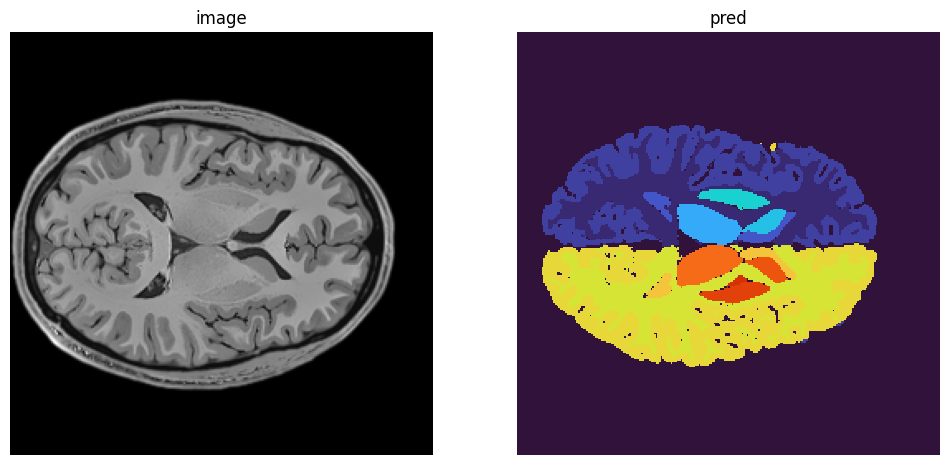

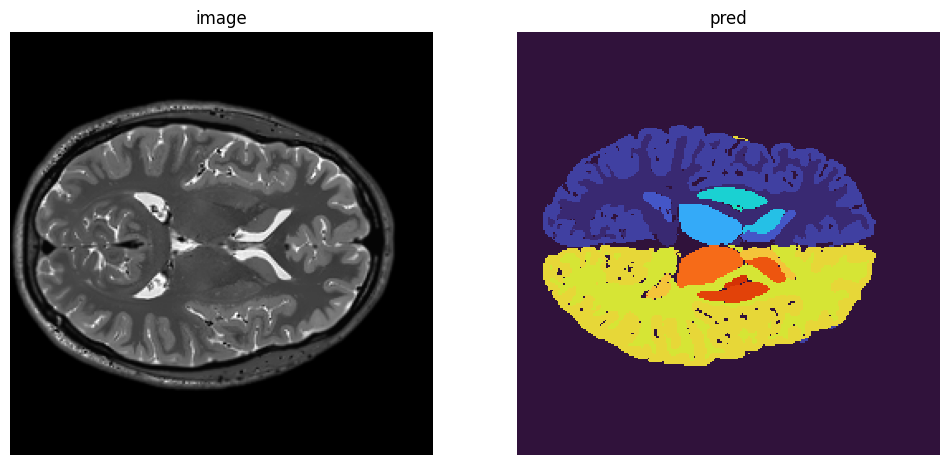

In [6]:
# Apply model to test data, showing predictions and calculating Dice scores
model.eval()
with torch.no_grad():
    for ix, batch_data in enumerate(test_loader):        
        image = batch_data["image"].to(device)
        
        pred = utils.inference(image, model, patch_size=patch_size)
        pred = [post_pred(i) for i in decollate_batch(pred)]

        plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title("image")
        plt.imshow(utils.extract_slice(image[0][0]).cpu().numpy(), cmap="gray")
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.title("pred")
        plt.imshow(utils.extract_slice(pred[0].argmax(0)).cpu().numpy(), cmap=cmap, norm=norm, interpolation="nearest")
        plt.show()                